# Fit Example Using SHG Optimisation From `scipy`

This example shows how to find the top hill in Great Britain, Ben Nevis, using [SHG Optimisation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html), a global optimiser from `scipy`.

## Optimisation

Ensure that you have downloaded the OS Terrain data:

In [1]:
import sys; sys.path.insert(0, '../') # Only for this repository
import nevis
nevis.download_os_terrain_50()
nevis.howdy() # Print the current version number

Downloaded, unpacked, and processed file already found: Skipping.

                |>          
 Starting Ben   |   Nevis   
               / \    Local
            /\/---\     0.0.5
           /---    \/\      
        /\/   /\   /  \     
     /\/  \  /  \_/    \    
    /      \/           \   


First, we load the linear interpolant on the GB height data from `nevis`. The interpolant takes two arguments, the coordinates x and y, and returns a scalar height. We then get the dimensions of the data, later used as bounds for optimisation.

In [2]:
f = nevis.linear_interpolant()
x_max, y_max = nevis.dimensions()

We use a list to remember visited points and create a callback to update the list:

In [3]:
points = []
def callback(xk):
    points.append(xk)

Next, we optimise the interpolant using [SHG Optimisation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html). We use sampling method `sobol` and number of sample points `2**16` in the construction of the simplicial complex (due to the large scale of the problem). The default local minimiser `SLSQP` is used. Note that we need a minus sign before our `f` to convert our problem to minimisation.

In [4]:
%%capture _
from scipy.optimize import shgo

result = shgo(
    func=lambda x: -f(*x),
    bounds=((0, x_max), (0, y_max)),
    callback=callback,
    sampling_method='sobol',
    n=2**16,
)

We then obtain the solution point and its corresponding function value. To find out where the optimiser has taken us to, we print the formatted result:

In [11]:
x, y = result.x
z = -result.fun
nevis.print_result(x, y, z)

Congratulations!
You landed at an altitude of 1345m.
  https://opentopomap.org/#marker=15/56.796765/-5.003525
You are 17m from the nearest named hill top, "Ben Nevis",
  ranked the 1st heighest in GB.
  http://hillsummits.org.uk/htm_summit/278.htm


We also print the number of function evaluations for benchmarking:

In [6]:
print(f'Number of function evaluations: {result.nfev}.')

Number of function evaluations: 693307.


## Plot

Some preparations for plotting the optimisation results:

In [7]:
import numpy as np

points = np.array(points)
c = nevis.Coords(gridx=x, gridy=y)
h, d = nevis.Hill.nearest(c) # Find the nearest hill and its distance to (x, y)

Figure 1: The whole map of GB showing Ben Nevis, our location, our nearest hill (which, in this case, happens to be Ben Nevis), and all visited points:

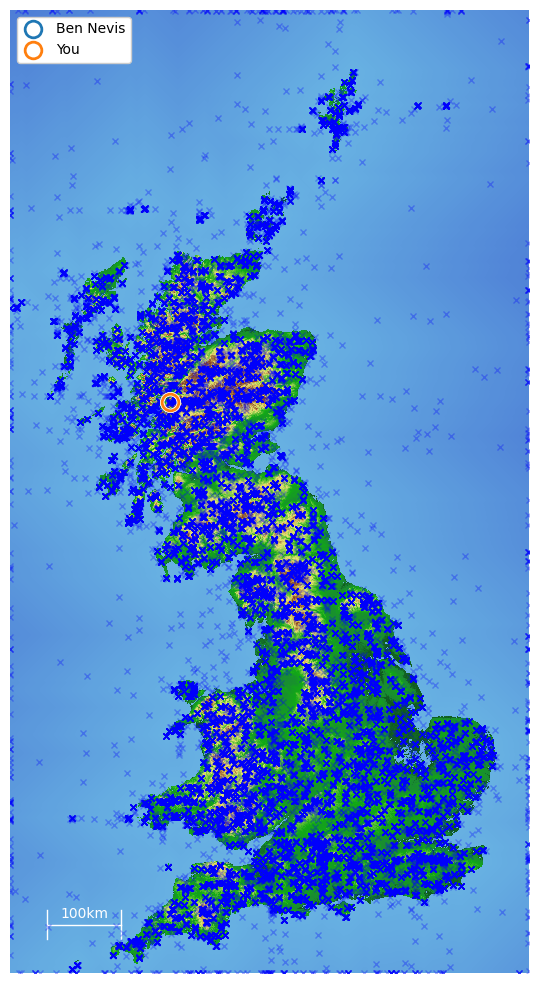

In [8]:
labels = {
    'Ben Nevis': nevis.ben(),
    h.name: h.coords,
    'You': c,
}
fig, ax, data, g = nevis.plot(
    labels=labels,
    points=points,
)

Figure 2: A zoomed map of a neighborhood of our location:

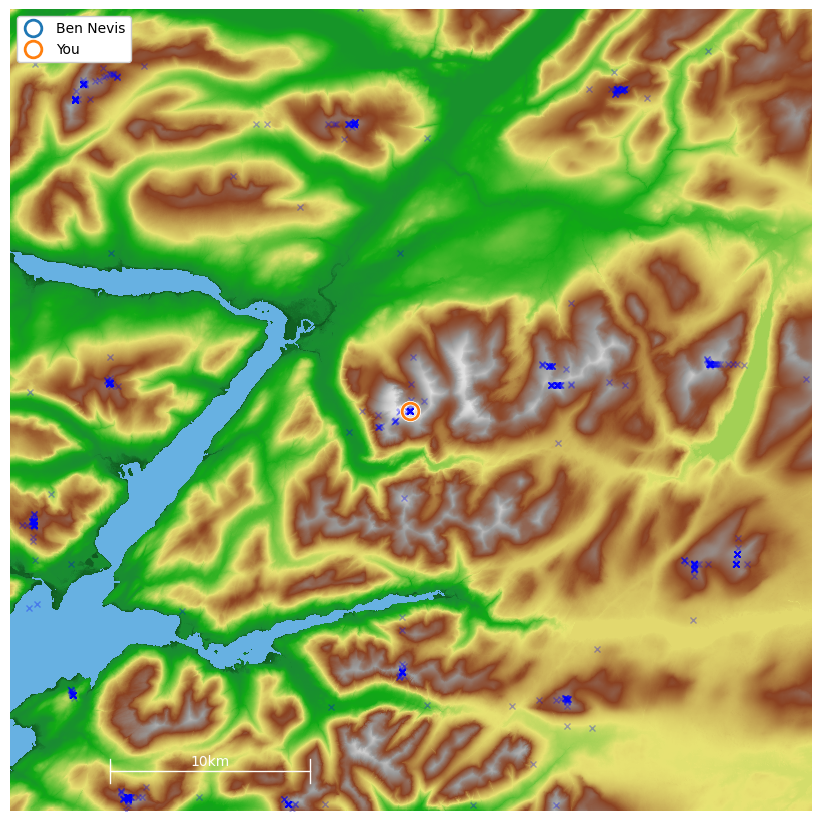

In [9]:
b = 20e3
boundaries = [x - b, x + b, y - b, y + b]
downsampling = 1
labels = {
    'Ben Nevis': nevis.ben(),
    h.name: h.coords,
    'You': c,
}
fig, ax, data, g = nevis.plot(
    boundaries=boundaries,
    labels=labels,
    points=points,
    downsampling=1,
)

Figure 3: Height along the line from the known hill to our location (note that there might be some discrepancies between a local maximum point of the interpolant and the corresponding hill in the database):

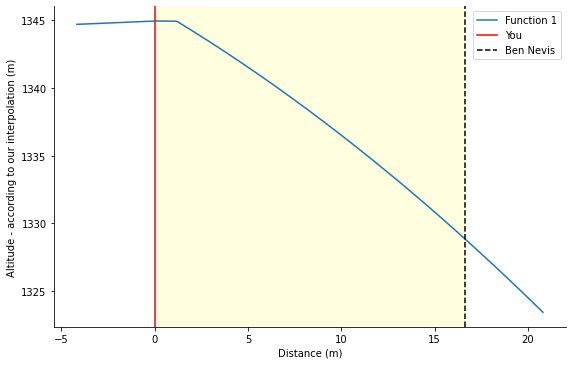

In [10]:
fig, ax, p1, p2 = nevis.plot_line(f, c, h.coords, 'You', h.name)